<a href="https://colab.research.google.com/github/danccas/SPAM-Detector/blob/master/spam_som.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import PorterStemmer as Stemmer
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Vamos a instalar los stopwords en caso no existan; además de la librería minisom

In [ ]:
!pip install minisom

from minisom import MiniSom
import nltk
nltk.download('stopwords')


  Created wheel for minisom: filename=MiniSom-2.2.6-cp36-none-any.whl size=8525 sha256=e856e501fbcfbad7767d9beba7dcb5c49bf315a673c9619d423efcf39c9cf846
  Stored in directory: /root/.cache/pip/wheels/b8/c6/01/330066e36e1f7c826c96f656f9185822cfcdef0591315949ea
Successfully built minisom
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Vamos a montar nuestro disco Drive, donde tenemos nuestro dataset de spam


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Importamos el dataset asignando dos columnas:

In [ ]:
read_file  = pd.read_csv('gdrive/My Drive/Colab Notebooks/SOM/datasets_483_982_spam.csv', encoding='latin-1')[['v1', 'v2']]
read_file.columns = ['label', 'message']
read_file.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Devuelve una tupla que representa la dimensionalidad del DataFrame

In [ ]:
read_file.shape

(5572, 2)

Vamos a realizar un agrupamiento por la etiqueta

In [ ]:
read_file.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Realziaremos una grafica del agrupamiento binario ham/spam

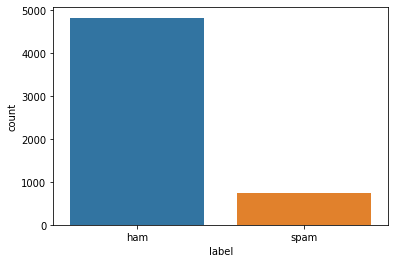

In [ ]:
sns.countplot(data=read_file, x='label')

Limpiar y normalizar texto, se realiza los siguientes pasos:

1.   Eliminar signos de puntuación
2.   Eliminar todas las palabras vacías
3.   Aplicar derivación (conversión a forma normal de palabra). Por ejemplo, 'conduciendo automóvil' y 'conduces automóvil' se convierte en conducir automóvil

In [ ]:
def text_processing(text_):
    text_ = text_.lower()
    text_ = ''.join([i for i in text_ if i not in string.punctuation])
    text_ = [i for i in text_.split() if i not in stopwords.words('english')]
    string_ = Stemmer()
    text_ = [string_.stem(i) for i in text_]
    return text_

text_processing('hello how are you fine//?')

['hello', 'fine']

Utilizaremos TfidfVectorizer. Convertirá la colección de documentos de texto (corpus de SMS) en una matriz 2D. Una dimensión representa documentos y otra dimensión repite cada palabra única en el corpus de SMS...

In [ ]:
tfidfv = TfidfVectorizer(analyzer=text_processing)  # Tfid
data_processing = tfidfv.fit_transform(read_file['message'])
type(data_processing)
data_processing = data_processing.toarray()  # convertirmos la matriz a un array para el modelo

In [ ]:
data_processing.shape # comprobar la forma de la matriz

(5572, 8097)

In [ ]:
labels =  read_file['label'] # almacena etiquetas en otra variable para que podamos usarlo para la comparación

In [ ]:
som_shape = (7, 7)
som = MiniSom(som_shape[0], som_shape[1], 8097, sigma=.5, learning_rate=.5, neighborhood_function='gaussian', random_seed=10)

som.train_batch(data_processing, 50, verbose=True)

 [ 50 / 50 ] 100% - 0:00:00 left 
 quantization error: 1.0369802115618354


Ahora consideraremos toda la muestra mapeada en una neurona específica como un grupo. Para identificar cada grupo más fácilmente, traduciremos los índices bidimensionales de las neuronas en el SOM en índices monodimensionales:

In [ ]:
# cada neurona representa un cluster
winner_coordinates = np.array([som.winner(x) for x in data_processing]).T
# con np.ravel_multi_index convertimos el bidimensional
# coordenadas a un índice monodimensional
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

Plottear

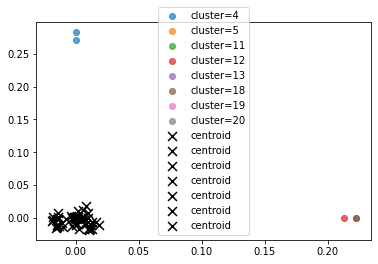

In [ ]:
# trazar los clusters utilizando las 2 primeras dimensiones de los datos
for c in np.unique(cluster_index):
    plt.scatter(data_processing[cluster_index == c, 0],
                data_processing[cluster_index == c,1], label='cluster='+str(c), alpha=.7)

# plottear centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', s=80, linewidths=35, color='k', label='centroid')
plt.legend();